**Let's prepare the data:**

In [1]:
from pandas.plotting import register_matplotlib_converters
from scipy.stats import pearsonr 
from scipy.stats import linregress
from sklearn.metrics import adjusted_mutual_info_score, mutual_info_score,normalized_mutual_info_score
from pingouin import distance_corr,linear_regression
from math import ceil, floor
from scipy.signal import get_window,csd,correlate
import requests 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import json
from hurst import compute_Hc
import hfda
sns.set(rc={'figure.figsize': (15, 8)})

Requesting of Dollar prices (data since 2002-01-11)

In [2]:
request_dollar_prices = requests.get('https://mercados.ambito.com//dolar/informal/historico-general/11-01-2002/10-01-2020')
Dollar_data = json.loads(request_dollar_prices.text)
Dollar = pd.DataFrame(Dollar_data[1: ], columns = ['Dates', 'Buyer', 'Selling'])
Dollar['Dates'] = pd.to_datetime(Dollar['Dates'], format = '%d-%m-%Y')  
Dollar = Dollar.replace({',':'.'}, regex=True)
Dollar.index = Dollar['Dates']
Dollar =  Dollar.drop(['Dates'], axis = 1)
Dollar['Buyer'] = Dollar['Buyer'].astype(float)
Dollar['Selling'] = Dollar['Selling'].astype(float)

In [3]:
inflation= pd.read_csv('data/inflation.csv', sep = ",")
price_index = pd.read_csv('data/Price_index.csv', sep = ",")
monetary_base = pd.read_csv('data/monetary_base.csv', sep = ",", thousands='.')
change_pbi = pd.read_csv('data/change_pbi.csv', sep = ",", decimal='.')

In [4]:
monetary_base['Dates'] = pd.to_datetime(monetary_base['Dates'], format = '%d/%m/%Y')    
monetary_base.index = monetary_base['Dates']
monetary_base = monetary_base.drop(['Dates'], axis = 1)

In [5]:
price_index['Mes'] = pd.to_datetime(price_index['Mes'], format = '%b-%y')
price_index = price_index.rename(columns = {'Mes' : 'Dates'})
price_index = price_index.replace({'%':''}, regex=True)
price_index.index = price_index['Dates']
price_index['% de var. mensual'] = price_index['% de var. mensual'].astype(float)
price_index = price_index.drop(['% de var. anual', 'Nivel', 'Dates'], axis = 1)
price_index = price_index.resample('1M').mean().dropna()
price_index = price_index.rename(columns = {'% de var. mensual' : 'Inflation'})

In [6]:
# Old Inflation Data
inflation['Dates'] = pd.to_datetime(inflation['Dates'], format = '%d/%m/%Y')    
inflation.index = inflation['Dates']
inflation = inflation.drop(['Dates'], axis = 1)

Replacing inflation values between 2007 and 2015

In [7]:
start, end = pd.to_datetime('2007-01-31'), pd.to_datetime('2015-12-31')
inflation.loc[start : end, 'Inflation'] = price_index.loc[start : end, 'Inflation']

Monetary Base with LELIQ and LEBAC

In [8]:
monetary_base_leliq_lebac = pd.read_csv('data/mb_leliq_lebac.csv', sep = ",", thousands = ',')
monetary_base_leliq_lebac['Fecha'] = pd.to_datetime(monetary_base_leliq_lebac['Fecha'], format = '%d-%b-%y')
monetary_base_leliq_lebac = monetary_base_leliq_lebac.rename(columns = {'Fecha' : 'Dates'})
monetary_base_leliq_lebac.index = monetary_base_leliq_lebac['Dates']
monetary_base_leliq_lebac = monetary_base_leliq_lebac.drop(['Dates'], axis = 1)

In [9]:
monetary_base_leliq_lebac['Saldo diario total'] = monetary_base_leliq_lebac['Saldo diario total'].astype('int32')
monetary_base_leliq_lebac['LELIQ'] = monetary_base_leliq_lebac['LELIQ'].astype('int32')
monetary_base_leliq_lebac['LEBAC y NOBAC'] = monetary_base_leliq_lebac['LEBAC y NOBAC'].astype('int32')
monetary_base_leliq_lebac['Monetary Base'] = monetary_base_leliq_lebac['Saldo diario total'] 


In [10]:
for column in monetary_base_leliq_lebac.columns:
    columns_to_keep = ['LELIQ', 'LEBAC y NOBAC', 'Monetary Base']
    if column not in columns_to_keep:
        monetary_base_leliq_lebac = monetary_base_leliq_lebac.drop(column, axis = 1)

In [11]:
monetary_base_leliq_lebac['cumulative LELIQ + LEBAC'] = monetary_base_leliq_lebac['LEBAC y NOBAC'].cumsum() + monetary_base_leliq_lebac['LELIQ'].cumsum()

In [12]:
monetary_base_leliq_lebac['Monetary Base'] -= monetary_base_leliq_lebac['cumulative LELIQ + LEBAC']

Replacing data from 2003

In [13]:
start, end = pd.to_datetime('2003-01-02'), pd.to_datetime('2019-12-31')
monetary_base.loc[start : end, 'Monetary Base'] = monetary_base_leliq_lebac.loc[start : end, 'Monetary Base']

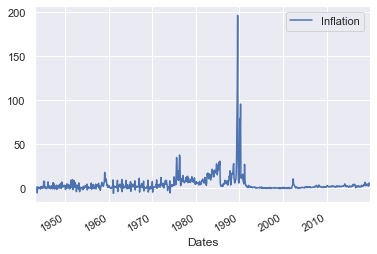

In [14]:
ax = inflation.plot()


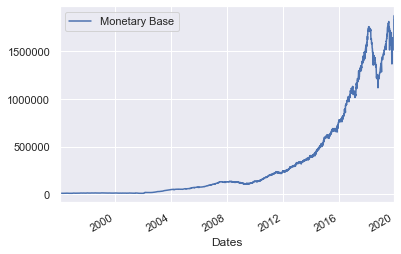

In [15]:
ax = monetary_base.plot()
#ax.set(yscale="log")

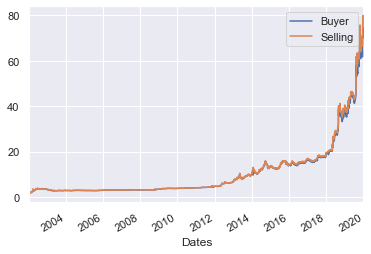

In [16]:
Dollar.plot()

In [17]:
inflation_1996 = {}
monetary_base_change_1996 = {}
dollar_change = {}
data_1996 = {}
months = [1, 3, 6, 12]
for m in months:
    inflation_1996[m] = inflation.truncate(before = '1996-01-01')
    inflation_1996[m] = inflation_1996[m].apply(lambda x : x/100+1)
    inflation_1996[m] = inflation_1996[m].resample(str(m) + 'M').apply(lambda x : x.cumprod()[-1])
    inflation_1996[m] = inflation_1996[m].apply(lambda x : (x - 1) * 100)
    monetary_base_change_1996[m] = monetary_base.truncate(before = '1996-01-01')
    monetary_base_change_1996[m] = monetary_base_change_1996[m].resample(str(m) + 'M').mean().pct_change()*100
    data_1996[m] = pd.DataFrame(monetary_base_change_1996[m])
    dollar_change[m] = Dollar['Selling'].resample(str(m) + 'M').mean().pct_change()*100
    data_1996[m] = data_1996[m].assign(Inflation = inflation_1996[m]['Inflation']).dropna()

**Now let's calculate the pearson correlation:**

In [18]:
pearson_lagged = {}
for m in months:
    max_lag = 12*4//m
    correlation=[]
    for lag in np.arange(0, max_lag + 1, 1):
        correlation.append(data_1996[m]['Inflation'].corr(data_1996[m]['Monetary Base'].shift(lag)))
    pearson_lagged[m]=correlation

In [19]:
to_plot = pd.DataFrame()
for m in months:
    to_plot=to_plot.append(pd.DataFrame([np.linspace(0,4,len(pearson_lagged[m])),pearson_lagged[m],[str(m)+ 'm']*len(pearson_lagged[m])]).T)
to_plot=to_plot.rename(columns={2:'months'})

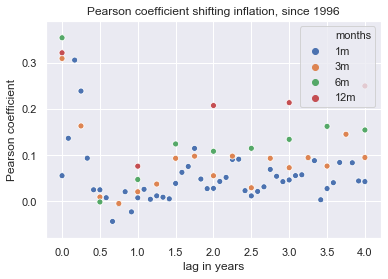

In [20]:
ax = sns.scatterplot(x= to_plot[0], y = to_plot[1], data = to_plot, hue = 'months')
ax.set(xlabel = 'lag in years', ylabel = 'Pearson coefficient', title = 'Pearson coefficient shifting inflation, since 1996')
ax

**Scatterplot: x = Change in Monetary Base and y = Inflation rate**

Text(0.5, 0, 'Change MB')

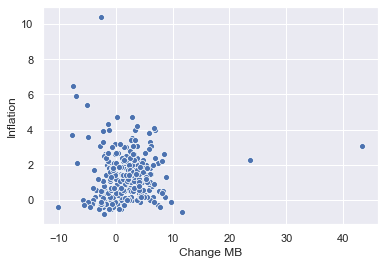

In [21]:
ax = sns.scatterplot(x = data_1996[1]['Monetary Base'], y = data_1996[1]['Inflation'])
ax.set_xlabel('Change MB')

**Scatterplot x = Change in Monetary Base shifted 12 months and y = Inflation**

Text(0.5, 0, 'Change MB')

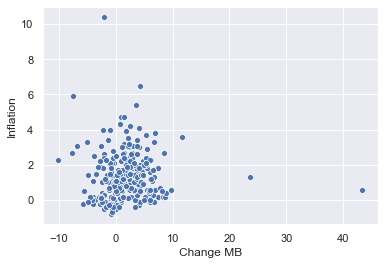

In [22]:
ax = sns.scatterplot(x = data_1996[1]['Monetary Base'].shift(12)[12:], y = data_1996[1]['Inflation'][12:])
ax.set_xlabel('Change MB')

**Scatterplot: x = Change in Monetary Base shifted 24 months and y = Inflation**

Text(0.5, 0, 'Change MB')

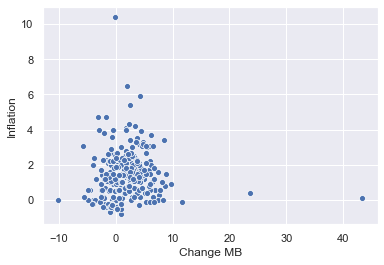

In [23]:
ax = sns.scatterplot(x = data_1996[1]['Monetary Base'].shift(24)[24:], y = data_1996[1]['Inflation'][24:])
ax.set_xlabel('Change MB')

**Scatterplot: x = Change in Monetary Base shifted 36 months and y = Inflation**

Text(0.5, 0, 'Change MB')

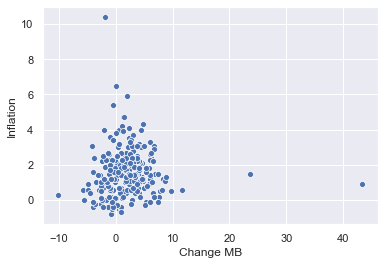

In [24]:
ax = sns.scatterplot(x = data_1996[1]['Monetary Base'].shift(36)[36:], y = data_1996[1]['Inflation'][36:])
ax.set_xlabel('Change MB')

**Now let's calculate the pearson coefficient of inflation and lagging the change in dollar price**

In [36]:
pearson_lagging_change_dollar = {}
for m in months:
    max_lag = 12*4//m
    correlation=[]
    for lag in np.arange(0, max_lag + 1, 1):
        correlation.append(data_1996[m]['Inflation'].truncate(before = '2002-01-11').corr(dollar_change[m].shift(lag)))
    pearson_lagging_change_dollar[m] = correlation

In [37]:
to_plot = pd.DataFrame()
for m in months:
    to_plot=to_plot.append(pd.DataFrame([np.linspace(0,4,len(pearson_lagging_change_dollar[m])),pearson_lagging_change_dollar[m],[str(m)+ 'm']*len(pearson_lagging_change_dollar[m])]).T)
to_plot=to_plot.rename(columns={2:'months'})

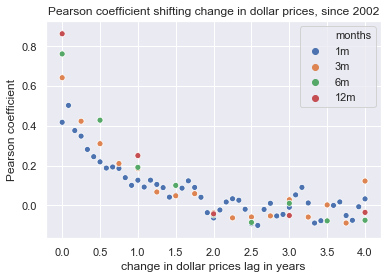

In [38]:
ax = sns.scatterplot(x= to_plot[0], y = to_plot[1], data = to_plot, hue = 'months')
ax.set(xlabel = 'change in dollar prices lag in years', ylabel = 'Pearson coefficient', title = 'Pearson coefficient shifting change in dollar prices, since 2002')
ax

**Scatterplot: Inflation vs Change in dollar price without lagging (Biannual data)"**

Text(0.5, 0, 'Change Dollar price')

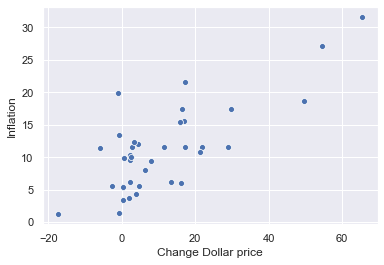

In [28]:
ax = sns.scatterplot(x = dollar_change[6], y = data_1996[6]['Inflation'].truncate(before = '2002-01-11'))
ax.set_xlabel('Change Dollar price')

Text(0.5, 0, 'Change Dollar price')

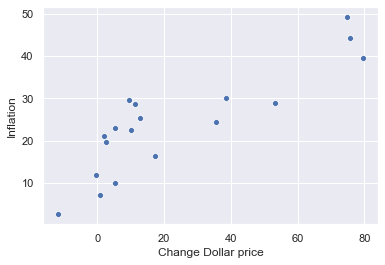

In [29]:
ax = sns.scatterplot(x = dollar_change[12], y = data_1996[12]['Inflation'].truncate(before = '2002-01-11'))
ax.set_xlabel('Change Dollar price')

**Scatterplot: Inflation vs Change in dollar price without lagging (Annual data)"**

**Hurst Exponent calculation**


In [30]:
H_Change_MB, c, data = compute_Hc(data_1996[1]['Monetary Base'].values, kind='change', simplified=True)
H_Change_MB

0.7176864821352322

In [31]:
H_Inflation, c, data = compute_Hc(data_1996[1]['Inflation'].values, kind='change', simplified=True)
H_Inflation

0.6928803033730169

Change in MB and Inflation have a **persistent behavior**

**calculating H index with a rolling window**

In [32]:
roll_months = 100
roll_Change_MB = data_1996[1]['Monetary Base'].rolling(roll_months, center = False)
roll_inflation = data_1996[1]['Inflation'].rolling(roll_months, center = False)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


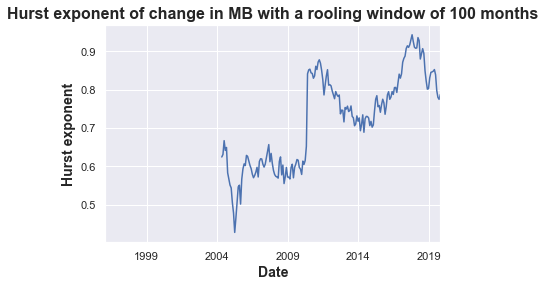

In [33]:
ax = roll_Change_MB.apply(lambda x : compute_Hc(x, kind='change', simplified=True)[0]).plot()
ax.set_title('Hurst exponent of change in MB with a rooling window of 100 months', weight='bold', fontsize = 16)
ax.set_ylabel('Hurst exponent', weight='bold', fontsize = 14)
ax.set_xlabel('Date', weight = 'bold', fontsize = 14)
ax

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


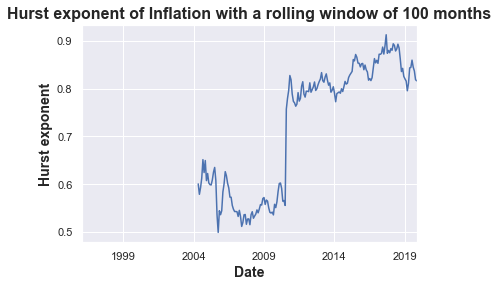

In [34]:
ax = roll_inflation.apply(lambda x : compute_Hc(x, kind='change', simplified=True)[0]).plot()
ax.set_title('Hurst exponent of Inflation with a rolling window of 100 months', weight = 'bold', fontsize = 16)
ax.set_ylabel('Hurst exponent', weight = 'bold',fontsize = 14)
ax.set_xlabel('Date', weight = 'bold', fontsize = 14)
ax

**Inflation vs change in (change in M2 - change in PBI) analysis**

In [35]:
change_pbi['Dates'] = pd.to_datetime(change_pbi['Dates'], format = '%Y')
change_pbi.index = change_pbi['Dates']
change_pbi = change_pbi.drop(['Dates'], axis = 1)

In [36]:
change_pbi=change_pbi.resample('Y').mean()

In [37]:
change_m2_pbi = monetary_base_change_1996[12][1 : -1]['Monetary Base'].resample('Y').mean().sub(change_pbi.truncate(before='1996-01-01').resample('y').mean()['change'][1:])

In [38]:
acceleration=change_m2_pbi.pct_change()*100

Text(0.5, 0, 'Change of (Change in MB)-(Change in PBI)')

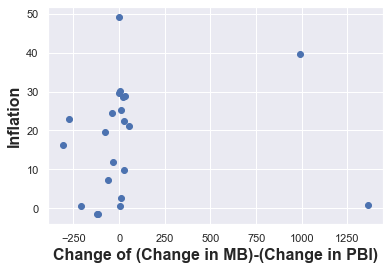

In [39]:
plt.plot(acceleration[1:], inflation_1996[12][2 : -1], 'o')
plt.ylabel('Inflation', weight = 'bold', fontsize = 16)
plt.xlabel('Change of (Change in MB)-(Change in PBI)', weight = 'bold', fontsize = 16)

**Frequency analysis**

In [212]:
from math import log10,pi

In [293]:
data_1996[6]['Monetary Base'].shape[-1]
freq = np.fft.fftfreq(data_1996[6]['Monetary Base'].shape[-1],1/2)


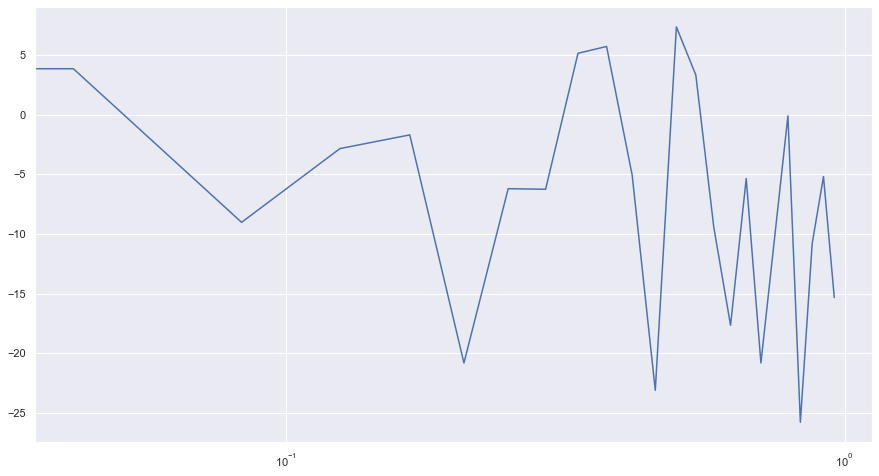

In [291]:
MB=np.fft.fft(data_1996[6]['Monetary Base'])
IN=np.fft.fft(data_1996[6]['Inflation'])
Cociente=abs(IN)/abs(MB)
plt.semilogx(freq[0:24],log[0:24],'-')
             



In [294]:
log=[20*log10(i) for i in Cociente]

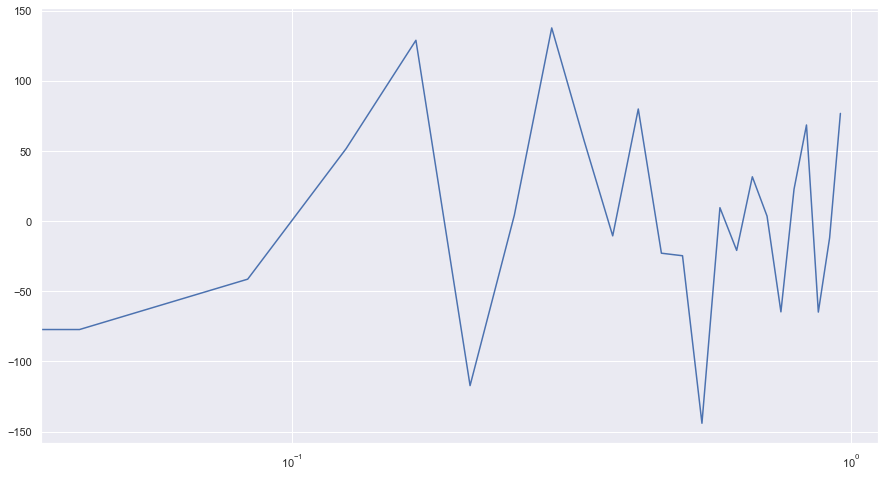

In [295]:
plt.semilogx(freq[0:24],180*np.angle(IN/MB)[0:24]/pi)

In [39]:
request = requests.get('https://apis.datos.gob.ar/series/api/dump/sspm/series-tiempo-valores-csv.zip')